In [68]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
from utilities import *
from utilities_train import *
from dataset import *

In [100]:
# file_dir="/Volumes/LaCie/gj_segmentation"
cell_mask_file_dir="/Volumes/LaCie/bigdata/masks"
mask_file_dir="/Volumes/LaCie/bigdata/gts"
img_file_dir="/Volumes/LaCie/bigdata/imgs"
img_file_paths = os.listdir(img_file_dir)
mask_file_paths = os.listdir(mask_file_dir)
cell_mask_file_paths = os.listdir(cell_mask_file_dir)

/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s014_Y8_X13.png.png
(512, 512)


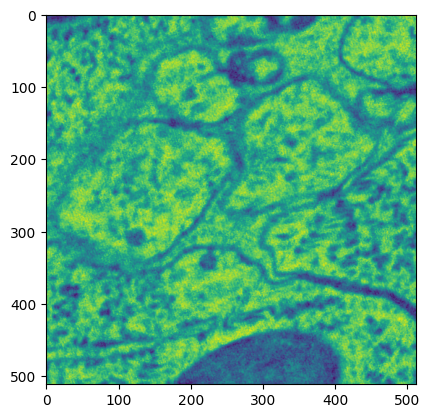

/Volumes/LaCie/bigdata/masks/20240325_SEM_dauer_2_nr_vnc_neurons_head_muscles.vsseg_export_s012_Y9_X16.png
(512, 512)


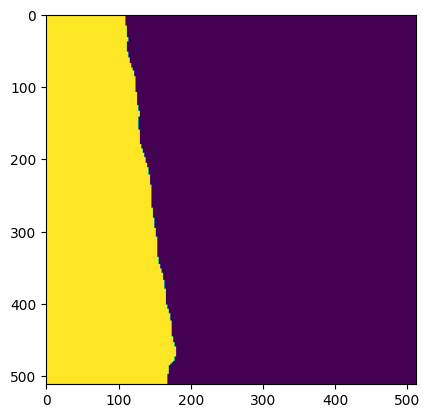

/Volumes/LaCie/bigdata/gts/sem2dauer_gj_2d_training.vsseg_export_s006_Y6_X6.png.png
(512, 512)


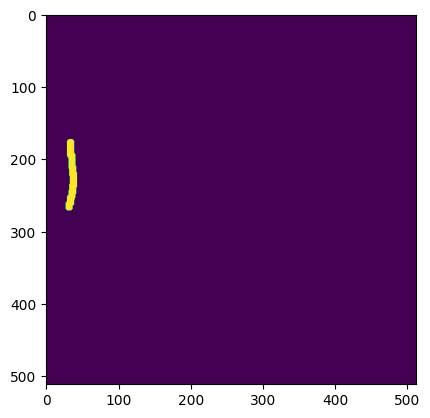

In [104]:
k=2
z,y,x=14,8,13
tmp_img = get_img_by_coords(z,y,x,img_file_paths, "SEM_dauer_2_image_export_s(\d+)_Y(\d+)_X(\d+).png.png")
tmp_mask = get_img_by_coords(z,y,x,mask_file_paths, "sem2dauer_gj_2d_training.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png.png")
tmp_cell_mask = get_img_by_coords(z,y,x,cell_mask_file_paths, "sem2dauer_gj_2d_training.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png.png")
print(tmp_img)
# fp=os.path.join(img_file_dir, img_file_paths[k])
# print(fp)
# tmp=cv2.imread(fp, cv2.COLOR_BGR2GRAY)
# print(tmp.shape)
# # print(np.unique(tmp, return_counts=True))
# plt.imshow(tmp)
# plt.show()
# fp=os.path.join(cell_mask_file_dir, cell_mask_file_paths[k])
# print(fp)
# tmp=cv2.imread(fp, cv2.COLOR_BGR2GRAY)
# print(tmp.shape)
# # print(np.unique(tmp, return_counts=True))
# plt.imshow(tmp)
# plt.show()
# fp=os.path.join(mask_file_dir, mask_file_paths[k])
# print(fp)
# tmp=cv2.imread(fp, cv2.COLOR_BGR2GRAY)
# print(tmp.shape)
# # print(np.unique(tmp, return_counts=True))
# plt.imshow(tmp)

In [35]:
# get all image and mask paths
data_dir = "/Volumes/LaCie/select_dauer_data_128"
# data_dir="/Users/huayinluo/Documents/code/gapjncsegmentation/data/small_data_512"
image_paths = []
mask_paths = []
pattern = r"(^|.*/)\d+\.npy$"
for root, dirs, files in os.walk(os.path.join(data_dir, "original")):
    for file in files:
        if re.match(pattern, file):
            image_paths.append(os.path.join(root, file))
for root, dirs, files in os.walk(os.path.join(data_dir, "ground_truth")):
    for file in files:
        if re.match(pattern, file):
            mask_paths.append(os.path.join(root, file))
print("Found {} images and {} masks".format(len(image_paths), len(mask_paths)))
c = list(zip(image_paths, mask_paths))
random.shuffle(c)
image_paths, mask_paths = zip(*c)
print(image_paths[:2])
print(mask_paths[:2])

Found 5774 images and 5774 masks
('/Volumes/LaCie/select_dauer_data_128/original/train/1255.npy', '/Volumes/LaCie/select_dauer_data_128/original/train/3046.npy')
('/Volumes/LaCie/select_dauer_data_128/ground_truth/train/1255.npy', '/Volumes/LaCie/select_dauer_data_128/ground_truth/train/3046.npy')


In [28]:
gj_percentages = []
for i in range(len(mask_paths)):
    print("Progress: {:.2f}%".format(i / len(mask_paths) * 100), end="\r")
    img = np.load(image_paths[i])
    mask = np.load(mask_paths[i])
    unique, counts = np.unique(mask, return_counts=True)
    try:
        percentage_gj = counts[1] / np.sum(counts)
    except:
        percentage_gj = 0
        continue
    gj_percentages.append(percentage_gj)

ValueError: cannot reshape array of size 0 into shape (3,128,128)

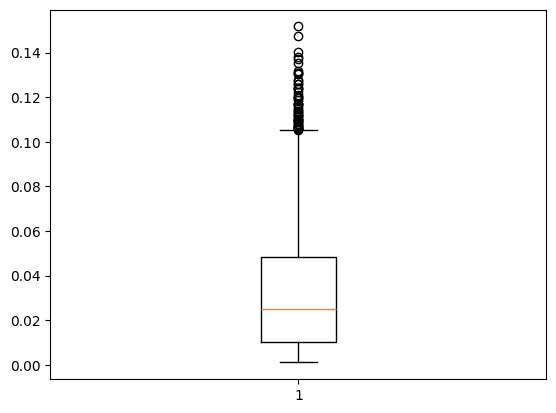

0.048258463541666664
0.024922688802083332
0.010213216145833334
0.0321296512602218


In [36]:
plt.boxplot(gj_percentages)
plt.show()
print(np.quantile(gj_percentages, 0.75))
print(np.quantile(gj_percentages, 0.5))
print(np.quantile(gj_percentages, 0.25))
print(np.mean(gj_percentages))

In [63]:
cutoff=0.02
num = 0
total = 10
selected_image_paths=[]
selected_mask_paths=[]
valid_slice=True
for i in range(len(mask_paths)):
    valid_slice=True
    # print("Progress: {:.2f}%".format(i / len(mask_paths) * 100), end="\r")
    img = np.load(image_paths[i])
    mask = np.load(mask_paths[i]) # (3, 512, 512)
    unique, counts = np.unique(mask, return_counts=True)
    
    # filter out examples on the edge
    depth = mask.shape[0]
    for j in range(depth):
        num_unique=len(np.unique(mask[j])) 
        if num_unique < 2:
            valid_slice=False
            break
        
    # save if doesn't have empty slice
    if valid_slice:
        try:
            percentage_gj = counts[1] / np.sum(counts)
        except:
            percentage_gj = 0
            continue
        if percentage_gj > cutoff:
            selected_image_paths.append(image_paths[i])
            selected_mask_paths.append(mask_paths[i])
            num+=1
        if num > total:
            break
print("Selected {} images and masks with gj percentage > {}".format(len(selected_image_paths), cutoff))

Selected 11 images and masks with gj percentage > 0.02


0 2
1 2
2 2


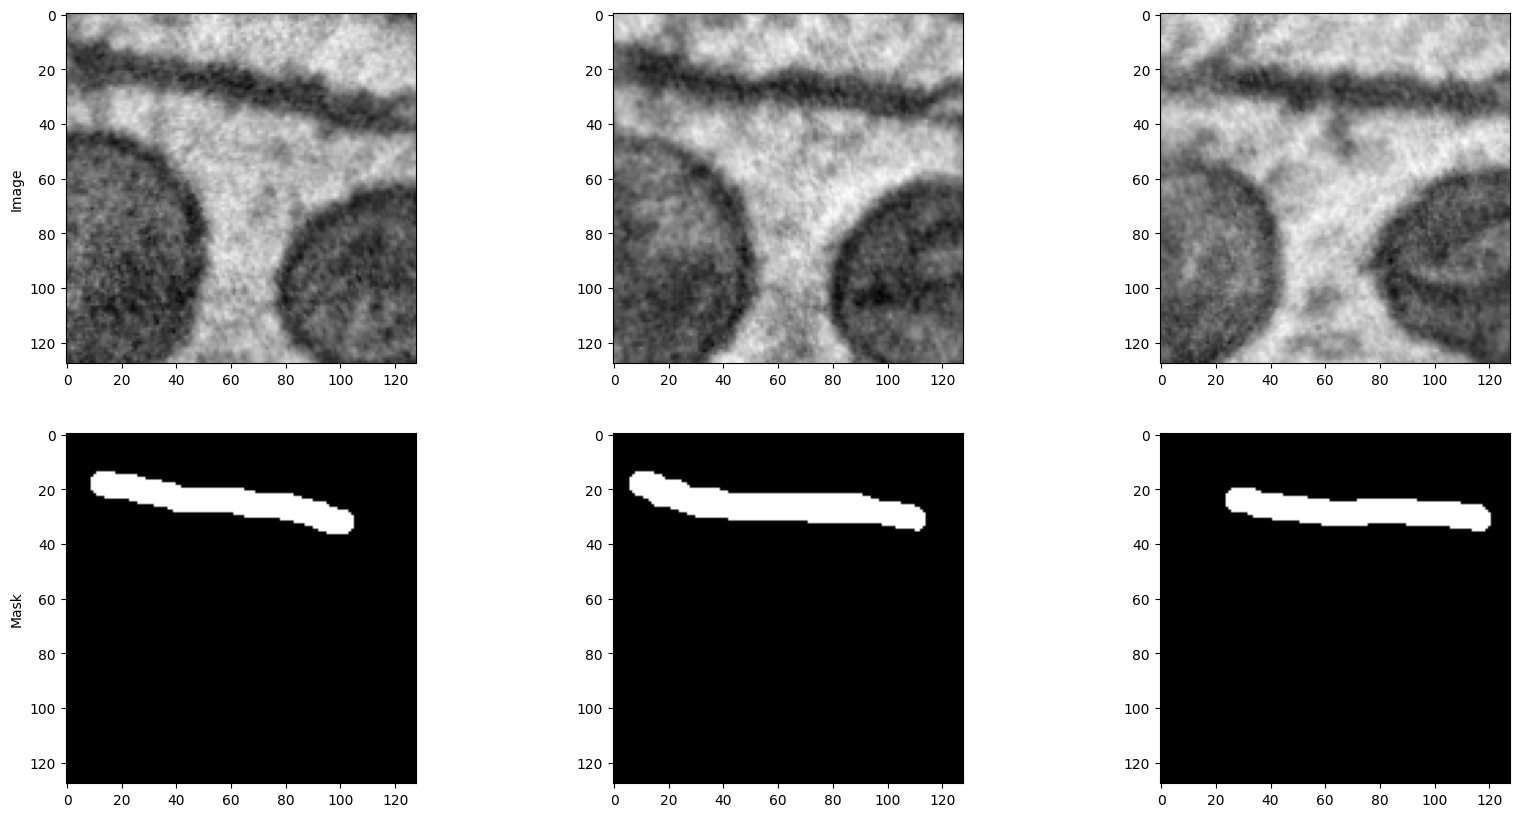

In [64]:
from utilities import *
k = 2
img = np.load(selected_image_paths[k])
mask = np.load(selected_mask_paths[k])
depth = mask.shape[0]
for i in range(depth):
    print(i, num_unique)
    num_unique=len(np.unique(mask[i]))
    if num_unique < 2:
        break
unique, counts = np.unique(mask, return_counts=True)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
visualize_3d_slice(img, ax[0], "Image")
visualize_3d_slice(mask, ax[1], "Mask")

In [65]:
# train test split
split = len(selected_image_paths) * 0.8
train_image_paths = selected_image_paths[:int(split)]
train_mask_paths = selected_mask_paths[:int(split)]
test_image_paths = selected_image_paths[int(split):]
test_mask_paths = selected_mask_paths[int(split):]
print("Train: {} images and {} masks".format(len(train_image_paths), len(train_mask_paths)))
print("Test: {} images and {} masks".format(len(test_image_paths), len(test_mask_paths)))

Train: 8 images and 8 masks
Test: 3 images and 3 masks


In [66]:
save_data_dir = "/Volumes/LaCie/tiny_dauer_data_128"
if not os.path.exists(save_data_dir):
    os.makedirs(save_data_dir)
create_train_valid_test_dir(save_data_dir)

In [67]:
for i in range(len(train_image_paths)):
    img = np.load(train_image_paths[i])
    mask = np.load(train_mask_paths[i])
    np.save(os.path.join(save_data_dir, "original", "train", "{}.npy".format(i)), img)
    np.save(os.path.join(save_data_dir, "ground_truth", "train", "{}.npy".format(i)), mask)
    print("train save progress {:.2f}%".format((i+1)/len(train_image_paths)*100), end="\r")

for i in range(len(test_image_paths)):
    img = np.load(test_image_paths[i])
    mask = np.load(test_mask_paths[i])
    np.save(os.path.join(save_data_dir, "original", "valid", "{}.npy".format(i)), img)
    np.save(os.path.join(save_data_dir, "ground_truth", "valid", "{}.npy".format(i)), mask)
    print("test save progress {:.2f}%".format((i+1)/len(test_image_paths)*100), end="\r")

# overfit

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
from utilities import *
from utilities_train import *
save_data_dir = "data/one_64"
if not os.path.exists(save_data_dir):
    os.makedirs(save_data_dir)
create_train_valid_test_dir(save_data_dir)

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# get all image and mask paths
data_dir = "data/tiniest_data_64"
image_paths = []
mask_paths = []
pattern = r"(^|.*/)\d+\.npy$"
for root, dirs, files in os.walk(os.path.join(data_dir, "original")):
    for file in files:
        if re.match(pattern, file):
            image_paths.append(os.path.join(root, file))
for root, dirs, files in os.walk(os.path.join(data_dir, "ground_truth")):
    for file in files:
        if re.match(pattern, file):
            mask_paths.append(os.path.join(root, file))
print("Found {} images and {} masks".format(len(image_paths), len(mask_paths)))
cutoff = 0.002
selected_image_paths = []
selected_mask_paths = []
for i in range(len(mask_paths)):
    img = np.load(image_paths[i])
    mask = np.load(mask_paths[i])
    depth, height, width = mask.shape
    total_pixels = depth * height * width
    num_ones = np.sum(mask[1])
    percentage_gj = num_ones / total_pixels
    if percentage_gj > cutoff:
        selected_image_paths.append(image_paths[i])
        selected_mask_paths.append(mask_paths[i])
    print("Progress: {:.2f}%".format((i+1)/len(mask_paths)*100), end="\r")
print("Selected {} images and masks with gj percentage > {}".format(len(selected_image_paths), cutoff))

Found 32 images and 32 masks
Selected 2 images and masks with gj percentage > 0.002


In [6]:
num_train = 1
num_test = 1
train_image_paths = selected_image_paths[:num_train]
train_mask_paths = selected_mask_paths[:num_train]
test_image_paths = selected_image_paths[num_train:num_train+num_test]
test_mask_paths = selected_mask_paths[num_train:num_train+num_test]
for i in range(len(train_image_paths)):
    img = np.load(train_image_paths[i])
    mask = np.load(train_mask_paths[i])
    np.save(os.path.join(save_data_dir, "original", "train", "{}.npy".format(i)), img)
    np.save(os.path.join(save_data_dir, "ground_truth", "train", "{}.npy".format(i)), mask)
    print("train save progress {:.2f}%".format((i+1)/len(train_image_paths)*100), end="\r")

print("finished train save")
for i in range(len(test_image_paths)):
    img = np.load(test_image_paths[i])
    mask = np.load(test_mask_paths[i])
    np.save(os.path.join(save_data_dir, "original", "test", "{}.npy".format(i)), img)
    np.save(os.path.join(save_data_dir, "ground_truth", "test", "{}.npy".format(i)), mask)
    print("test save progress {:.2f}%".format((i+1)/len(test_image_paths)*100), end="\r")
    

finished train save 100.00%


percentage_gj: 0.021630859375


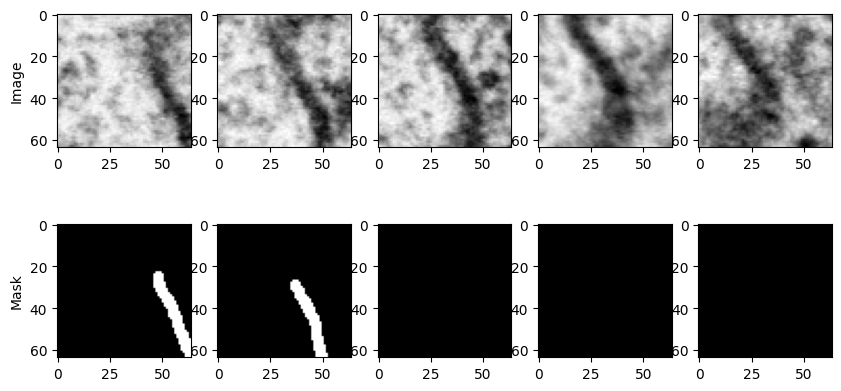

In [7]:
from utilities import *
for i in range(len(train_image_paths)):
    img = np.load(train_image_paths[i])
    mask = np.load(train_mask_paths[i])
    unique, counts = np.unique(mask, return_counts=True)
    percentage_gj = counts[1] / np.sum(counts)
    print("percentage_gj: {}".format(percentage_gj))
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    visualize_3d_slice(img, ax[0], "Image")
    visualize_3d_slice(mask, ax[1], "Mask")
    plt.show()

percentage_gj: 0.0037811279296875


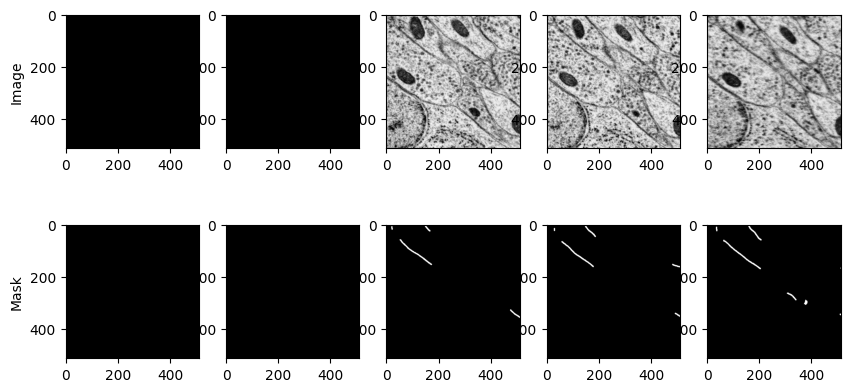

In [32]:
for i in range(len(test_image_paths)):
    img = np.load(test_image_paths[i])
    mask = np.load(test_mask_paths[i])
    unique, counts = np.unique(mask, return_counts=True)
    percentage_gj = counts[1] / np.sum(counts)
    print("percentage_gj: {}".format(percentage_gj))
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    visualize_3d_slice(img, ax[0], "Image")
    visualize_3d_slice(mask, ax[1], "Mask")
    plt.show()